1. Data loading and exploration

In [ ]:
 ! pip install -q kaggle

In [ ]:
from google.colab import files


In [ ]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"alekseysut","key":"0f7778e3f46701f904d0b9712573b0e0"}'}

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets list

ref                                                          title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
-----------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
victorsoeiro/netflix-tv-shows-and-movies                     Netflix TV Shows and Movies                           2MB  2022-05-15 00:01:23           6978        218  1.0              
devansodariya/student-performance-data                       Student Performance Dataset                           7KB  2022-05-26 13:55:09           2995        125  0.9705882        
iamsouravbanerjee/software-professional-salaries-2022        Salary Dataset - 2022                               526KB  2022-06-10 06:02:59           1081         34  1.0              
paradisejoy/top-hits-spotify-from-20002019                   Top Hits Spoti

In [ ]:
!kaggle datasets download -d abhikjha/appa-real-face-cropped


 97% 221M/228M [00:02<00:00, 90.9MB/s]
100% 228M/228M [00:02<00:00, 87.3MB/s]


In [ ]:
! mkdir age_dataset

In [ ]:
! unzip appa-real-face-cropped.zip -d age_dataset/

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: age_dataset/final_files/final_files/002592.jpg  
  inflating: age_dataset/final_files/final_files/002593.jpg  
  inflating: age_dataset/final_files/final_files/002594.jpg  
  inflating: age_dataset/final_files/final_files/002595.jpg  
  inflating: age_dataset/final_files/final_files/002596.jpg  
  inflating: age_dataset/final_files/final_files/002597.jpg  
  inflating: age_dataset/final_files/final_files/002598.jpg  
  inflating: age_dataset/final_files/final_files/002599.jpg  
  inflating: age_dataset/final_files/final_files/002600.jpg  
  inflating: age_dataset/final_files/final_files/002601.jpg  
  inflating: age_dataset/final_files/final_files/002602.jpg  
  inflating: age_dataset/final_files/final_files/002603.jpg  
  inflating: age_dataset/final_files/final_files/002604.jpg  
  inflating: age_dataset/final_files/final_files/002605.jpg  
  inflating: age_dataset/final_files/final_files/002606.jpg  
  

In [ ]:
#necessary libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

import warnings
warnings.filterwarnings('ignore')

The dataset is stored in the /content/age_dataset, there you can find

-  The /content/age_dataset/null folder with 7.6k photos
- The /content/age_dataset/labels.csv file with labels, with two columns: file_name and real_age

In [ ]:
#load labels.csv and observe it
labels = pd.read_csv('/content/age_dataset/labels.csv')
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


Let's qucikly check the age distribution of photos

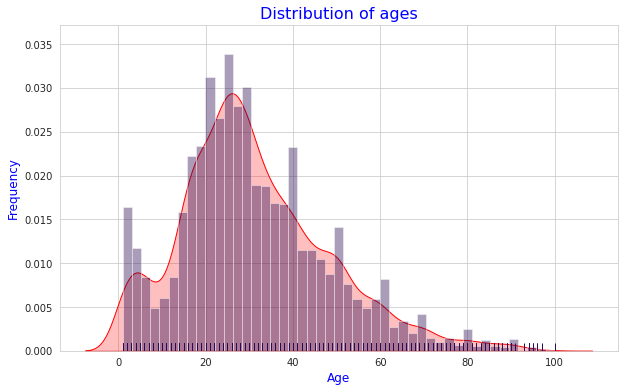

In [ ]:
plt.figure(figsize=(10, 6))
sns.set_style('whitegrid')
sns.set_palette('inferno')
sns.distplot(labels['real_age'], rug=True, kde_kws={'shade':True, 'color':'r'})
plt.xlabel('Age', fontsize=12, color='b')
plt.ylabel('Frequency', fontsize=12, color='b')
plt.title('Distribution of ages', fontsize=16, color='b')
plt.show()

Given the fact that the number of image files is rather high, it is advisable to avoid reading them all at once, which would greatly consume computational resources. Hence, we will use the ImageDataGenerator generator: class from Keras, that forms batches with images and labels (class for classification, for instance) based on the photos in a directory.

In [ ]:
# create datagenerator object for training and validation datasets
#rescale images using 1/255
train_datagen = ImageDataGenerator(vertical_flip=True,
            #we will do normalization for image pixel values as following
            rescale=1 / 255
            )

#use flow_from_dataframe method to load images from directory and labels from dataframe
train_datagen_flow = train_datagen.flow_from_dataframe(
    dataframe = labels,
    directory='/content/age_dataset/final_files/final_files',
    x_col="file_name", 
    y_col="real_age",
    #we are doing regression, so we will assign class_mode to 'raw'
    class_mode="raw",
    #to convert all images to same pixel size, for neural networks, all images should have similar size
    target_size=(224,224),
    #we will load images batch by batch (every time 32 images will be loaded)
    batch_size=32,
    seed=12345,
        )

Found 7591 validated image filenames.


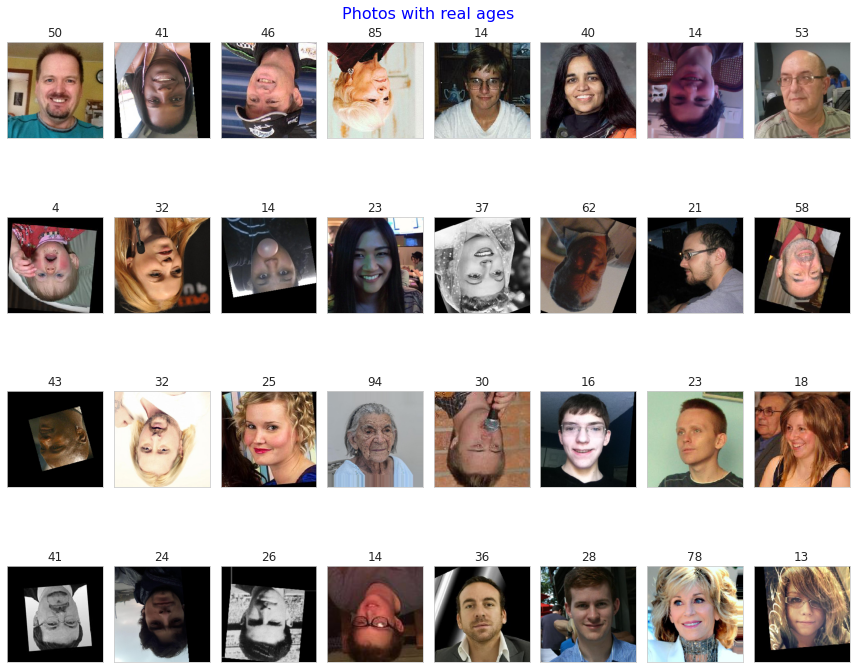

In [ ]:
#get one batch from our datagenerator and display images in it
features, target = next(train_datagen_flow)

# display 16 images
fig = plt.figure(figsize=(12,12))
for i in range(32):
    fig.add_subplot(4, 8, i+1)
    plt.imshow(features[i])
    plt.title(f'{target[i]}')
	# remove axes and place the images closer to one another for a more compact output
    plt.xticks([])
    plt.yticks([])
    plt.suptitle('Photos with real ages',  y=0.9,fontsize=16, color='b')
    plt.tight_layout()

2. Defining necessary functions for neural network

In [ ]:
def load_train(path):
    
    """
    It loads the train part of dataset from path
    """
    
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(validation_split=0.25, vertical_flip=True, rescale=1 / 255)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset = 'training',
        seed=12345)

    return train_gen_flow


In [ ]:
def load_test(path):
    
    """
    It loads the validation/test part of dataset from path
    """
    labels = pd.read_csv(path + 'labels.csv')
    validation_datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255)
    test_gen_flow = validation_datagen.flow_from_dataframe(
    dataframe = labels,
    directory=path +'final_files/final_files/',
    x_col="file_name",
    y_col="real_age", 
    class_mode="raw", 
    target_size=(224,224), 
    batch_size=32,
    subset = "validation",
    seed=12345,
    )

    return test_gen_flow

In [ ]:
def create_model(input_shape):
    
    """
    It defines the model
    """
    # we will use ResNet50 architecture, with freezing top layers
    backbone = ResNet50(input_shape=input_shape, weights='imagenet', include_top=False)
    model = Sequential()
    model.add(backbone)
    
    #now we will add our custom layers
    #without drop layer, neural networks can easily overfit
    model.add(Dropout(0.2))
    model.add(GlobalAveragePooling2D())
    
    #final layer, since we are doing regression we will add only one neuron (unit)
    model.add(Dense(1, activation='relu'))
    optimizer = Adam(lr=0.0003)
    model.compile(optimizer=optimizer, loss='mae', metrics=['mae'])
    print(model.summary())

    return model


In [ ]:
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    """
    Trains the model given the parameters
    """
    
    model.fit(train_data, validation_data=test_data, batch_size=batch_size, 
              epochs=epochs, steps_per_epoch=steps_per_epoch, 
              validation_steps=validation_steps, verbose=2)

    return model

Calling functions

In [ ]:
#assign data directory
path = '/content/age_dataset/'

In [ ]:
#load training and testing (actually this is validation data set)
train_data = load_train(path)
test_data = load_test(path)

Found 5694 validated image filenames.
Found 1897 validated image filenames.


In [ ]:
#build a model
model = create_model(input_shape = (224, 224, 3))

94781440/94765736 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 dropout (Dropout)           (None, 7, 7, 2048)        0         
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1)                 2049      
                                                                 
Total params: 23,589,761
Trainable params: 23,536,641
Non-trainable params: 53,120
_________________________________________________________________
None


In [ ]:
#train the model
model = train_model(model, train_data, test_data)

Epoch 1/20
178/178 - 89s - loss: 11.3098 - mae: 11.3098 - val_loss: 20.8221 - val_mae: 20.8221 - 89s/epoch - 502ms/step
Epoch 2/20
178/178 - 69s - loss: 8.8899 - mae: 8.8899 - val_loss: 15.4036 - val_mae: 15.4036 - 69s/epoch - 386ms/step
Epoch 3/20
178/178 - 69s - loss: 8.0674 - mae: 8.0674 - val_loss: 16.3716 - val_mae: 16.3716 - 69s/epoch - 388ms/step
Epoch 4/20
178/178 - 71s - loss: 7.4229 - mae: 7.4229 - val_loss: 12.2070 - val_mae: 12.2070 - 71s/epoch - 397ms/step
Epoch 5/20
178/178 - 69s - loss: 7.0755 - mae: 7.0755 - val_loss: 8.6931 - val_mae: 8.6931 - 69s/epoch - 389ms/step
Epoch 6/20
178/178 - 70s - loss: 6.5473 - mae: 6.5473 - val_loss: 12.8130 - val_mae: 12.8130 - 70s/epoch - 391ms/step
Epoch 7/20
178/178 - 70s - loss: 6.2933 - mae: 6.2933 - val_loss: 7.8649 - val_mae: 7.8649 - 70s/epoch - 395ms/step
Epoch 8/20
178/178 - 70s - loss: 5.8110 - mae: 5.8110 - val_loss: 7.6501 - val_mae: 7.6501 - 70s/epoch - 392ms/step
Epoch 9/20
178/178 - 70s - loss: 5.4876 - mae: 5.4876 - val_

We have achieved quite good MAE, which can predict age of person with  ±  6.4.
By the way, in one article about this dataset we are working with, the lowest MAE value reached is 5.4. This paper was published in 2017 by ETH Computer Vision researhcer. We also did quite well by getting MAE of 6.4 compared to 5.4.